# Úvod

![mood](https://miro.medium.com/v2/resize:fit:518/format:webp/1*iEkoBTURLU8t2NYeOPTIYw.jpeg)

Pro vytvoření datasetu Action-Camera Parking Dataset
([ACPDS](https://arxiv.org/abs/2107.12207)) autoři použili kameru _GoPro Hero
6_, kterou připevnili na **12 metrů** dlouhou teleskopickou tyč. Tímto způsobem
získali možnost zachytit různá parkoviště a ulice z jedinečných pohledů.

Fotografie byly pořízeny z výšky již zmíněných 12 metrů, což odpovídá běžné
výšce pouličních lamp. Tato vlastnost je velmi důležitá pro praktické použití,
protože fotografie budou lépe odrážet reálné situace, které mohou nastat.
Celkově autoři zachytili 293 fotografií.

[Odkaz](https://github.com/martin-marek/parking-space-occupancy) na GitHub
repozitář atorů s všechnymi potřebnými informacemi a soubory.


# Načtení knihoven


In [3]:
import io
import os
import random
import zipfile

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2
import torch

# Stažení a načtení dat


In [4]:
dataset_dir = 'data/parking_dataset'

In [5]:
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    with requests.get('https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2Frois_gopro.zip', stream=True) as response:
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        t = tqdm.tqdm(total=total_size, unit='iB', unit_scale=True)
        buffer = io.BytesIO()
        for data in response.iter_content(block_size):
            t.update(len(data))
            buffer.write(data)
        t.close()
        if total_size != 0 and t.n != total_size:
            print("ERROR, something went wrong")
        buffer.seek(0)
        zip = zipfile.ZipFile(buffer)
    zip.extractall(dataset_dir)
    print('Data downloaded and extracted')
else:
    print('Data already exists')

Data already exists


In [6]:
print(os.listdir(dataset_dir))

['annotations.json', 'images']


Nyní máme dostupné dvě položky:

- `images` - složka obsahující fotografie parkovišť
- `annotations.json` - soubor obsahující anotace k fotografiím

Pojdmě se na ně podívat.


# Fotografie

Fotografie jsou uloženy ve složce `images`. Nyní si zobrazíme několik z nich.


In [7]:
images_dir = os.path.join(dataset_dir, 'images')

In [8]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [9]:
len(os.listdir(images_dir))

293

Dostáváme přesně stejný počet fotografií, jaký byl zmíněn autory v datasetu.
Parádá!


## Vizualizace fotografií


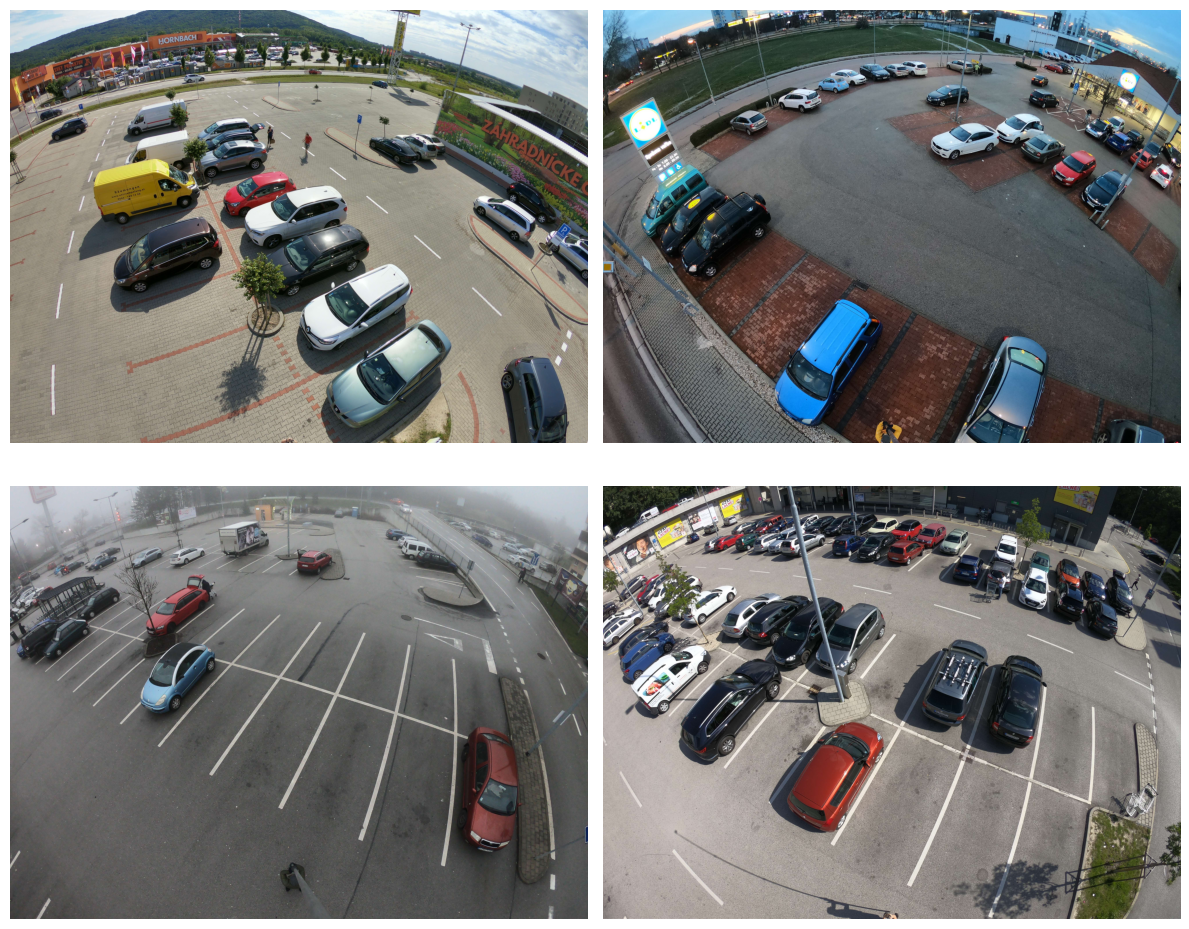

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

random_images = random.sample(os.listdir(images_dir), 4)

for i, img_name in enumerate(random_images):
    image_path = os.path.join(images_dir, img_name)
    image = load_image(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Jsou to převážně pouliční parkoviště, která jsou vidět zhruba z výšky 12 metrů.
Jsou mírně rozostřené ptačí perspektivou, ale stále je možné rozpoznat
jednotlivá auta. Koneckonců, to je hlavní cíl tohoto datasetu a jednotlivá místa
jsou označena pomocí anotací s tímto mírným rozostřením.


# Anotace

Anotace jsou stejně důležité jako samotné fotografie. Bez nich by bylo obtížné
využít tento dataset pro trénování modelů strojového učení. Anotace obsahují
informace o jednotlivých parkovacích místech, jako je jejich poloha, velikost a
obsazenost.

Bez nich by nebylo možné trénovat modely a říct jim, co mají dělat, jaké jsou
jejich cíle a jaké jsou výsledky. Anotace jsou tedy klíčovým prvkem datasetu.

Anotace nebudou tak přímočaré, jak by se mohlo zdát. Podívejme se na ně podívat
podrobněji a zjistit, jaké informace obsahují.


In [11]:
json_annotations = pd.read_json(os.path.join(dataset_dir, 'annotations.json'))

In [12]:
print("\nColumns:", json_annotations.columns.tolist())
print("\nIndex:", json_annotations.index.tolist())

for column in json_annotations.columns:
    print(f"\n{column}:")
    for idx in json_annotations.index:
        data = json_annotations.loc[idx, column]
        print(f"\t{idx}: {len(data)} items")
        if len(data) > 0 and isinstance(data[0], list):
            print(f"\t\tFirst item contains {len(data[0])} elements")


Columns: ['test', 'train', 'valid']

Index: ['file_names', 'occupancy_list', 'rois_list']

test:
	file_names: 27 items
	occupancy_list: 27 items
		First item contains 76 elements
	rois_list: 27 items
		First item contains 76 elements

train:
	file_names: 231 items
	occupancy_list: 231 items
		First item contains 13 elements
	rois_list: 231 items
		First item contains 13 elements

valid:
	file_names: 35 items
	occupancy_list: 35 items
		First item contains 69 elements
	rois_list: 35 items
		First item contains 69 elements


Zde vidíme, že anotace obsahují následující informace:

- **rozdělení dat** - informace o tom, zda je fotografie součástí trénovacího,
  validačního nebo testovacího datasetu
  - **názvy souborů** - názvy fotografií, které jsou součástí daného datasetu
  - **ROIS (region of interest)** - list oblasti zájmu, které byly anotovány
    autory datasetu
  - **stav parkovacího místa** - list informací o tom, zda je parkovací místo
    obsazené nebo volné

Důležité je správně pochopit, jak jsou tyto informace strukturovány, abychom
mohli správně použít tento dataset pro trénování modelů.


## Vizualizace anotací na fotografii


Selected file: GOPR6799.JPG
Number of parking spaces: 61
Occupied spaces: 36
Free spaces: 25


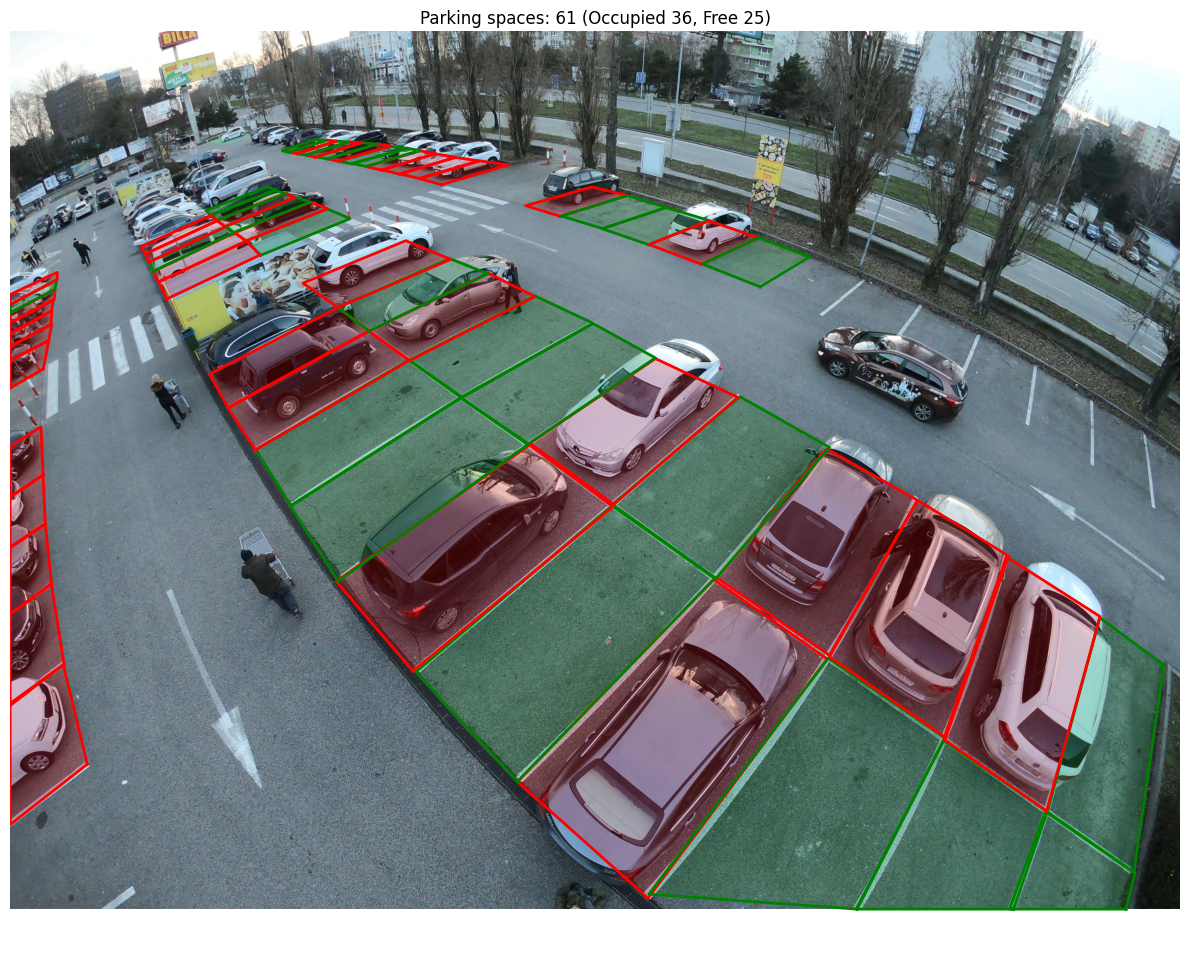

In [14]:
random_pick_file = random.choice(json_annotations['train']['file_names'])
print(f"Selected file: {random_pick_file}")

idx = json_annotations['train']['file_names'].index(random_pick_file)
rois = json_annotations['train']['rois_list'][idx]
occupancy = json_annotations['train']['occupancy_list'][idx]

print(f"Number of parking spaces: {len(occupancy)}")
print(f"Occupied spaces: {occupancy.count(True)}")
print(f"Free spaces: {occupancy.count(False)}")

image_path = os.path.join(images_dir, random_pick_file)
image = load_image(image_path)

plt.figure(figsize=(12, 10))
plt.imshow(image)

for i in range(len(rois)):
    roi = np.array(rois[i])
    is_occupied = occupancy[i]
    edge_color = 'red' if is_occupied else 'green'
    fill_color = ('red' if is_occupied else 'green', 0.2)  # transparency

    # Scale the ROI coordinates to match the image size
    x = roi[:, 0] * image.shape[1]
    y = roi[:, 1] * image.shape[0]

    plt.plot(np.append(x, x[0]), np.append(y, y[0]), color=edge_color, linewidth=2)
    plt.fill(x, y, color=fill_color)

plt.axis('off')
plt.title(f"Parking spaces: {len(occupancy)} (Occupied {occupancy.count(True)}, Free {occupancy.count(False)})")
plt.tight_layout()
plt.show()